In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
import torch.optim as optim


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

In [3]:
dataset_nm = 'mnist'
x,y = 'image', 'label'
ds = load_dataset(dataset_nm)

Found cached dataset mnist (/Users/arun/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 112.23it/s]


In [4]:
def transform_ds(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

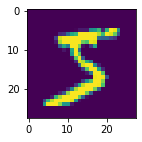

In [5]:
dst = ds.with_transform(transform_ds)
plt.imshow(dst['train'][0]['image'].permute(1,2,0));

In [6]:
bs = 1024
class DataLoaders:
    def __init__(self, train_ds, valid_ds, bs, collate_fn, **kwargs):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, **kwargs)
        self.valid = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, **kwargs)

def collate_fn(b):
    collate = default_collate(b)
    return (collate[x], collate[y])

In [7]:
dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [147]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.reshape(self.dim)

In [148]:
def conv(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=s, padding=ks//2)]
    if norm:
        layers.append(norm)
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None):
    return nn.Sequential(
        conv(ni, nf, ks=ks, s=1, norm=norm, act=act),
        conv(nf, nf, ks=ks, s=s, norm=norm, act=act),
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, s=2, ks=3, act=nn.ReLU, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, s=s, ks=ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, s=1, act=None)
        self.pool = fc.noop if s==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [149]:
# def cnn_classifier():
#     return nn.Sequential(
#         ResBlock(1, 8, norm=nn.BatchNorm2d(8)),
#         ResBlock(8, 16, norm=nn.BatchNorm2d(16)),
#         ResBlock(16, 32, norm=nn.BatchNorm2d(32)),
#         ResBlock(32, 64, norm=nn.BatchNorm2d(64)),
#         ResBlock(64, 64, norm=nn.BatchNorm2d(64)),
#         conv(64, 10, act=False),
#         nn.Flatten(),
#     )

def cnn_classifier():
    return nn.Sequential(
        ResBlock(1, 8,),
        ResBlock(8, 16, ),
        ResBlock(16, 32,),
        ResBlock(32, 64, ),
        ResBlock(64, 64,),
        conv(64, 10, act=False),
        nn.Flatten(),
    )

In [150]:
def kaiming_init(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        nn.init.kaiming_normal_(m.weight)        

In [151]:
model = cnn_classifier()
model.apply(kaiming_init)
lr = 0.1
max_lr = 0.3
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)
for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        total_loss = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
                total_loss  += loss.item()
        if train:
            sched.step()
        accuracy /= len(dl)
        total_loss /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {total_loss:.4f}, accuracy: {accuracy:.4f}")

train, epoch:1, loss: 1.3684, accuracy: 0.5153
eval, epoch:1, loss: 0.4238, accuracy: 0.8648
train, epoch:2, loss: 0.2660, accuracy: 0.9162
eval, epoch:2, loss: 0.1468, accuracy: 0.9552
train, epoch:3, loss: 0.1479, accuracy: 0.9545
eval, epoch:3, loss: 0.1101, accuracy: 0.9647
train, epoch:4, loss: 0.1149, accuracy: 0.9650
eval, epoch:4, loss: 0.0997, accuracy: 0.9705
train, epoch:5, loss: 0.2118, accuracy: 0.9399
eval, epoch:5, loss: 0.1625, accuracy: 0.9478


In [152]:
for epoch in range(epochs):
        train = False
        accuracy = 0
        total_loss = 0
        dl = dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
                total_loss  += loss.item()
        accuracy /= len(dl)
        total_loss /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {total_loss:.4f}, accuracy: {accuracy:.4f}")

eval, epoch:1, loss: 0.1625, accuracy: 0.9478
eval, epoch:2, loss: 0.1625, accuracy: 0.9478
eval, epoch:3, loss: 0.1625, accuracy: 0.9478
eval, epoch:4, loss: 0.1625, accuracy: 0.9478
eval, epoch:5, loss: 0.1625, accuracy: 0.9478


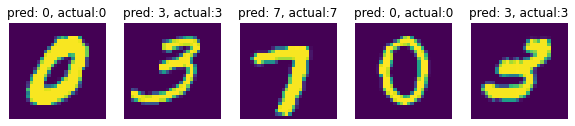

In [153]:
xbv,ybv = next(iter(dls.train))
logits = model(xbv)
probs = F.softmax(logits, dim=1)
idx = 5
_,axs = plt.subplots(1, idx, figsize=(10, 10))
for actual, pred, im, ax in zip(ybv[:idx], probs[:idx],xbv.permute(0,2,3,1)[:idx], axs.flat):
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f'pred: {pred.argmax(0).item()}, actual:{actual.item()}')
    

In [158]:
torch.save(model.state_dict(), 'classifier.pth')

In [159]:
loaded_model = cnn_classifier()
loaded_model.load_state_dict(torch.load('classifier.pth'));
loaded_model.eval();

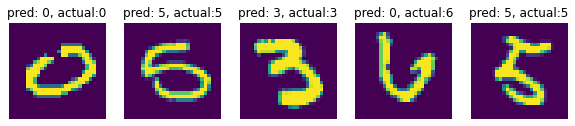

In [160]:
with torch.no_grad():
    xbv,ybv = next(iter(dls.train))
    logits = loaded_model(xbv)
    probs = F.softmax(logits, dim=1)
    idx = 5
    _,axs = plt.subplots(1, idx, figsize=(10, 10))
    for actual, pred, im, ax in zip(ybv[:idx], probs[:idx],xbv.permute(0,2,3,1)[:idx], axs.flat):
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_title(f'pred: {pred.argmax(0).item()}, actual:{actual.item()}')
        

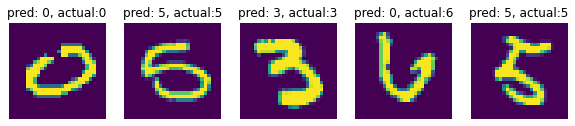

In [161]:
logits = model(xbv)
probs = F.softmax(logits, dim=1)
idx = 5
_,axs = plt.subplots(1, idx, figsize=(10, 10))
for actual, pred, im, ax in zip(ybv[:idx], probs[:idx],xbv.permute(0,2,3,1)[:idx], axs.flat):
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f'pred: {pred.argmax(0).item()}, actual:{actual.item()}')
    

In [164]:
def predict(img):
    with torch.no_grad():
        img = img[None,]
        pred = loaded_model(img)[0]
        pred_probs = F.softmax(pred, dim=0)
        pred = [{"digit": i, "prob": f'{prob*100:.2f}%', 'logits': pred[i]} for i, prob in enumerate(pred_probs)]
        pred = sorted(pred, key=lambda ele: ele['digit'], reverse=False)
    return pred

In [167]:
img = xb[1].reshape(1, 28, 28)
print(yb[1])
predict(img)

tensor(4)


[{'digit': 0, 'prob': '0.12%', 'logits': tensor(-1.1319)},
 {'digit': 1, 'prob': '0.00%', 'logits': tensor(-4.7852)},
 {'digit': 2, 'prob': '2.15%', 'logits': tensor(1.7912)},
 {'digit': 3, 'prob': '0.07%', 'logits': tensor(-1.6584)},
 {'digit': 4, 'prob': '97.03%', 'logits': tensor(5.5990)},
 {'digit': 5, 'prob': '0.01%', 'logits': tensor(-3.5289)},
 {'digit': 6, 'prob': '0.00%', 'logits': tensor(-4.4016)},
 {'digit': 7, 'prob': '0.09%', 'logits': tensor(-1.3343)},
 {'digit': 8, 'prob': '0.07%', 'logits': tensor(-1.6577)},
 {'digit': 9, 'prob': '0.45%', 'logits': tensor(0.2194)}]

#### commit to .py file for deployment

In [168]:
!jupyter nbconvert --to script --TagRemovePreprocessor.remove_cell_tags="exclude" --TemplateExporter.exclude_input_prompt=True mnist_classifier.ipynb


[NbConvertApp] Converting notebook mnist_classifier.ipynb to script
[NbConvertApp] Writing 3187 bytes to mnist_classifier.py
